### 本程式碼專注於 對RUL資料進行 套模 ###

### 函式宣告 引入模型 ###

D:\Pycharm_conda_projects\NTU rul data analysis\NTU_rul_models\time_series_models\CCAE_direct_lstm_multiscale_emf_Base256Future256


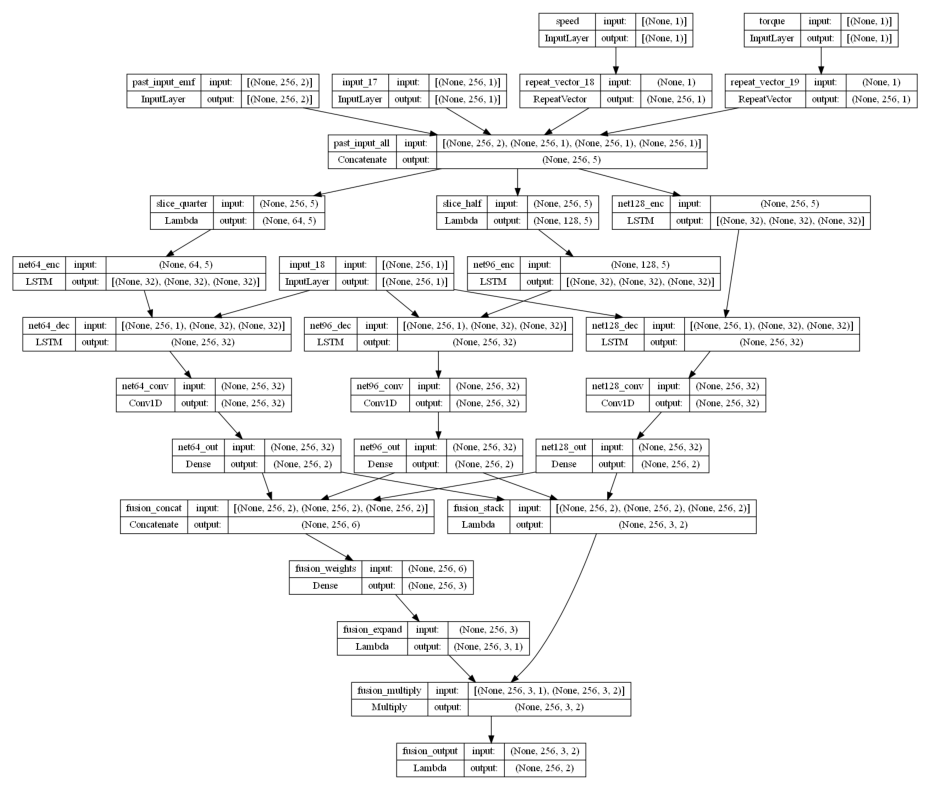

{
    "model_name": "CCAE_direct_lstm_multiscale_emf_Base256Future256",
    "sequence_length": 256,
    "layer_number": 1,
    "created_at": "2025-07-29 13:30:46",
    "trained": true,
    "train_date": null
}


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import random
import json
np.random.seed(42)
random.seed(42)

future_length = 256
sequence_length = 256

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = 'CCAE_direct_lstm_multiscale_emf_Base256Future256'
model_path=os.path.join(r'D:\Pycharm_conda_projects\NTU rul data analysis\NTU_rul_models\time_series_models', model_name)
print(model_path)



my_model=load_model(os.path.join(model_path, model_name + '.keras'))
plt.figure(figsize=(20, 10))
plt.imshow(plt.imread(os.path.join(model_path, model_name + '.png')))
plt.axis('off')
plt.show()

# 讀取 metadata.json
metadata_path = os.path.join(model_path, model_name + '_metadata.json')
with open(metadata_path, "r", encoding="utf-8") as f:
    metadata_loaded = json.load(f)

# 印出
print(json.dumps(metadata_loaded, ensure_ascii=False, indent=4))


# 假設你已經定義好了這些（要根據你自己的實作引入）
# from your_module import read_rul_data, 
# , my_model, Rs, Fs, sequence_length, future_length

def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data


def compute_file_error(file_path, sequence_length, future_length, augmen_sample_number, Rs, Fs):
    df = read_rul_data(file_path)

    # 建立 input signals (shape: [length, 4])
    signals = np.stack([
        np.array(df["Voltage alpha downsample"]),
        np.array(df["Voltage beta downsample"]),
        np.array(df["Current alpha downsample"]),
        np.array(df["Current beta downsample"])
    ], axis=1)

    # Augmentation: 建立多段 (sequence + future) 時間序列資料
    augmented = data_random_augmentation(
        signals,
        sequence_length=sequence_length,
        augmen_sample_number=augmen_sample_number,
        future_length=future_length
    )
    
    input_seq = augmented[:, :sequence_length, :]    # [batch, seq, 4]
    future_seq = augmented[:, sequence_length:, :]   # [batch, future, 4]

    # 單一值特徵
    torque = df["Torque avg"]
    speed = df["Speed"][0] / 3000  # PU

    torque_array = np.ones((augmen_sample_number, 1)) * torque
    speed_array_pu = np.ones((augmen_sample_number, 1)) * speed

    # 角度 theta
    time_sequence_all = np.arange(0, sequence_length + future_length)[None, :, None] / Fs
    theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi
    past_theta = theta_all_rad[:, :sequence_length, :]
    future_theta = theta_all_rad[:, sequence_length:, :]

    # emf 計算
    emf_past = (input_seq[:, :, 0:2] - input_seq[:, :, 2:4] * Rs) / (speed_array_pu[:, None, :] * 3000 / 60 * 2 * np.pi)
    emf_future_true = (future_seq[:, :, 0:2] - future_seq[:, :, 2:4] * Rs) / (speed_array_pu[:, None, :] * 3000 / 60 * 2 * np.pi)

    # 預測未來
    emf_future_pred = my_model.predict([emf_past, past_theta, speed_array_pu, torque_array, future_theta], verbose=0)

    # 計算每段 MSE 並平均
    mse_per_sample = np.mean((emf_future_pred - emf_future_true) ** 2, axis=(1, 2))  # shape = (augmen_sample_number,)
    return np.mean(mse_per_sample)  # 該檔案的平均 MSE


def process_rul_folder_avg_mse(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs):
    rul_files = [os.path.join(RUL_test_folder, f) for f in os.listdir(RUL_test_folder) if f.endswith(".parquet")]
    rul_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    all_file_errors = []
    for file_path in rul_files:
        file_mse = compute_file_error(file_path, sequence_length, future_length, augmen_sample_number, Rs, Fs)
        all_file_errors.append(file_mse)
        # print(f"{os.path.basename(file_path)} MSE: {file_mse:.6f}")
        
    return np.array(all_file_errors)

    # 排序回原順序
    results.sort(key=lambda x: rul_files.index(x[0]))
    errors = [r[1] for r in results]
    return np.array(errors)




In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rul_features.rul_data_read import read_rul_data

# 假設你已經定義好了這些（要根據你自己的實作引入）
# from your_module import read_rul_data, 
# , my_model, Rs, Fs, sequence_length, future_length

def process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs):
    rul_files = [os.path.join(RUL_test_folder, f) for f in os.listdir(RUL_test_folder) if f.endswith(".parquet")]
    rul_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    # 用來累積所有檔案的 augmentation 結果
    all_input_seq = []
    all_future_seq = []
    all_torque = []
    all_speed = []
    file_index_ranges = []

    total_index = 0

    for file_path in rul_files:
        df = read_rul_data(file_path)

        signals = np.stack([
            np.array(df["Voltage alpha downsample"]),
            np.array(df["Voltage beta downsample"]),
            np.array(df["Current alpha downsample"]),
            np.array(df["Current beta downsample"])
        ], axis=1)

        augmented = data_random_augmentation(
            signals,
            sequence_length=sequence_length,
            augmen_sample_number=augmen_sample_number,
            future_length=future_length
        )

        input_seq = augmented[:, :sequence_length, :]
        future_seq = augmented[:, sequence_length:, :]

        torque = df["Torque avg"]
        speed = df["Speed"][0] / 3000

        torque_array = np.ones((augmen_sample_number, 1)) * torque
        speed_array_pu = np.ones((augmen_sample_number, 1)) * speed

        all_input_seq.append(input_seq)
        all_future_seq.append(future_seq)
        all_torque.append(torque_array)
        all_speed.append(speed_array_pu)

        file_index_ranges.append((total_index, total_index + augmen_sample_number))
        total_index += augmen_sample_number

    # 合併所有資料
    input_seq_all = np.concatenate(all_input_seq, axis=0)
    future_seq_all = np.concatenate(all_future_seq, axis=0)
    torque_all = np.concatenate(all_torque, axis=0)
    speed_all = np.concatenate(all_speed, axis=0)

    # theta 計算
    time_sequence_all = np.arange(0, sequence_length + future_length)[None, :, None] / Fs
    theta_all_rad = speed_all[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi
    past_theta = theta_all_rad[:, :sequence_length, :]
    future_theta = theta_all_rad[:, sequence_length:, :]

    # emf 計算
    emf_past = (input_seq_all[:, :, 0:2] - input_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)
    emf_future_true = (future_seq_all[:, :, 0:2] - future_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)

    # 批量預測
    emf_future_pred = my_model.predict([emf_past, past_theta, speed_all, torque_all, future_theta], verbose=0)

    # 計算每段 MSE
    mse_per_sample = np.mean((emf_future_pred - emf_future_true) ** 2, axis=(1, 2))

    # 回分每個檔案的平均 MSE
    errors = []
    for start_idx, end_idx in file_index_ranges:
        file_mse = np.mean(mse_per_sample[start_idx:end_idx])
        errors.append(file_mse)

    return np.array(errors)




In [36]:

# 自行修改成你的資料路徑
RUL_test_folder = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0701_1200_10p_2.0V_3"

#變數宣告
Fs=20000
Rs=12.5
augmen_sample_number = 100

# 主程式：取得每個檔案的平均 MSE
errors = process_rul_folder_avg_mse(RUL_test_folder, 256, 256, augmen_sample_number, Rs, Fs)

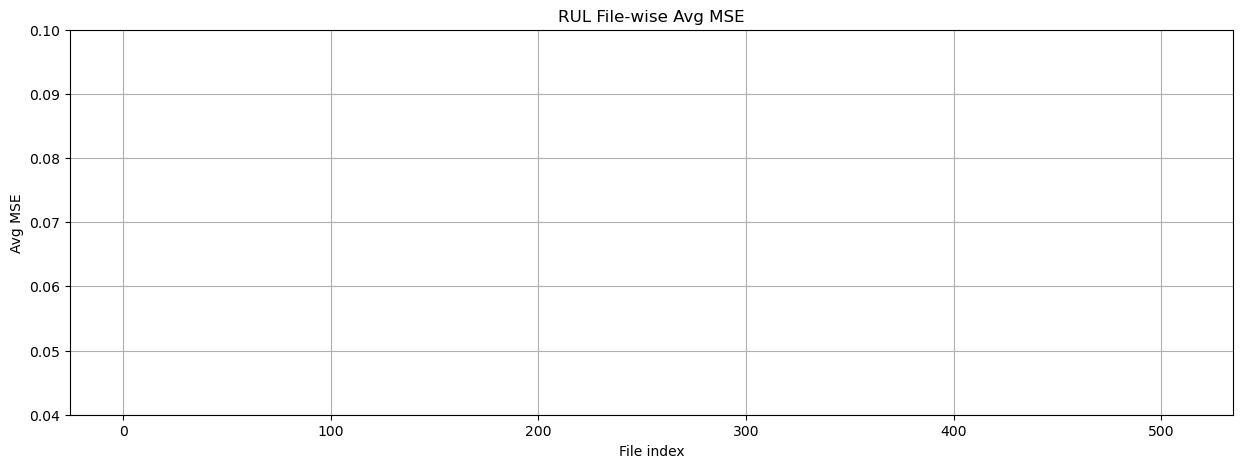

In [39]:
# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors)
plt.title("RUL File-wise Avg MSE")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

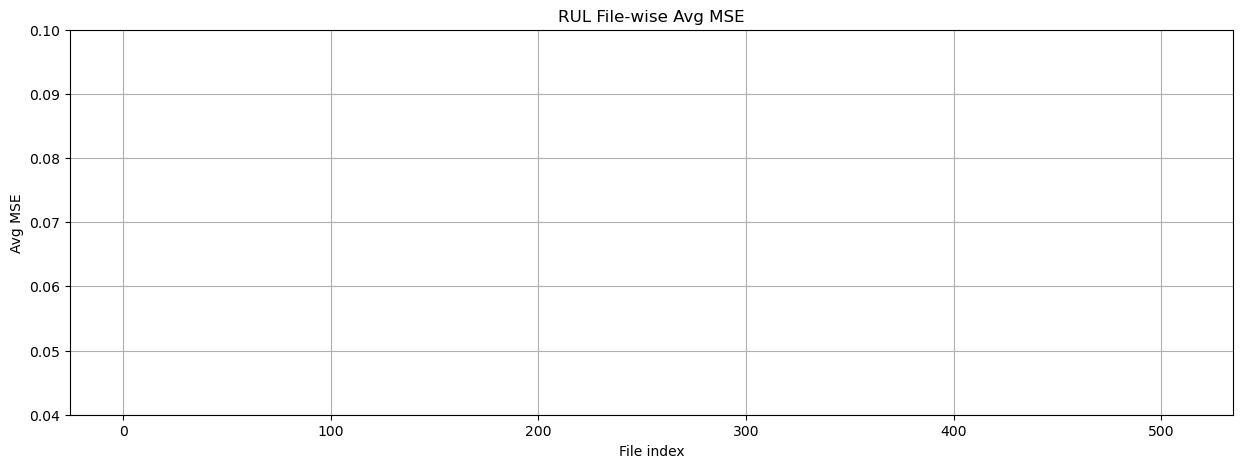

In [ ]:

# 自行修改成你的資料路徑
RUL_test_folder = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0701_1200_10p_2.0V_3"
Rs=12.5
F=20000
augmen_sample_number = 100

# 主程式：取得每個檔案的平均 MSE
errors1 = process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs)


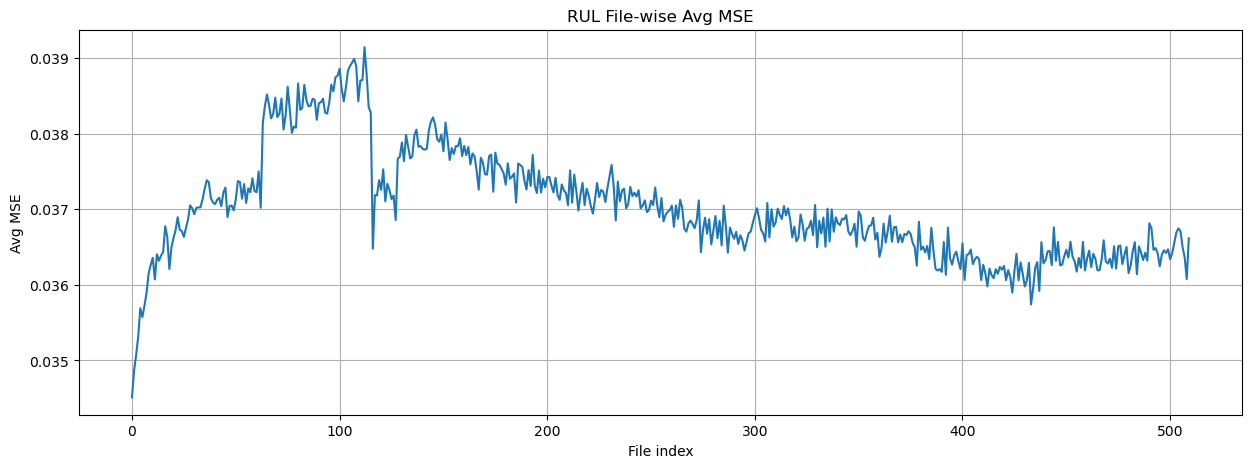

In [31]:

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors1)
plt.title("RUL File-wise Avg MSE")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

In [32]:
# 自行修改成你的資料路徑
RUL_test_folder = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0707_3000_10p_1.0v_2"
Rs=12.5
F=20000
augmen_sample_number = 100


# 主程式：取得每個檔案的平均 MSE
errors2 = process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs)


KeyboardInterrupt: 

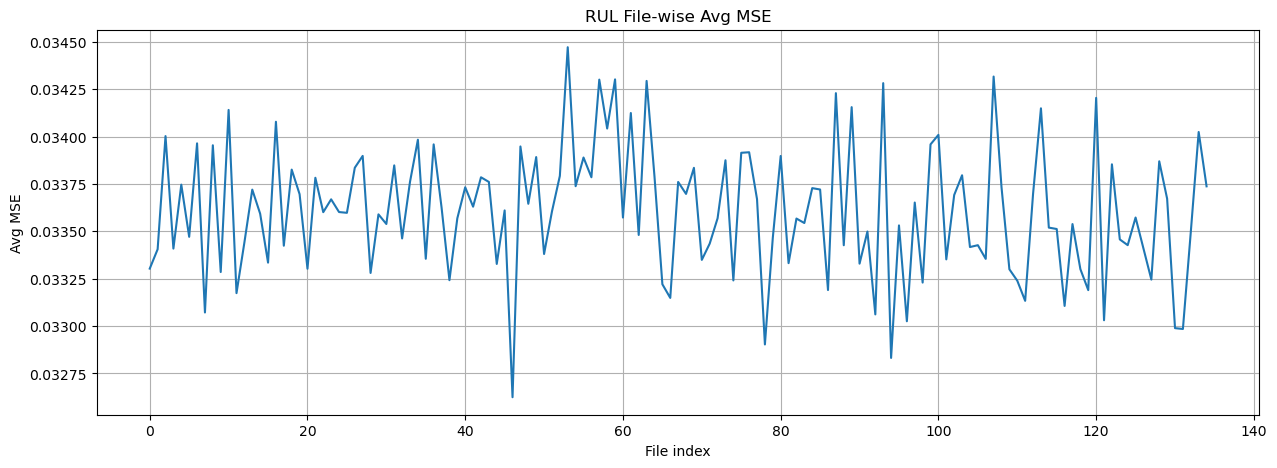

In [40]:

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors2)
plt.title("RUL File-wise Avg MSE")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0, 0.1)
plt.grid()
plt.show()

Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

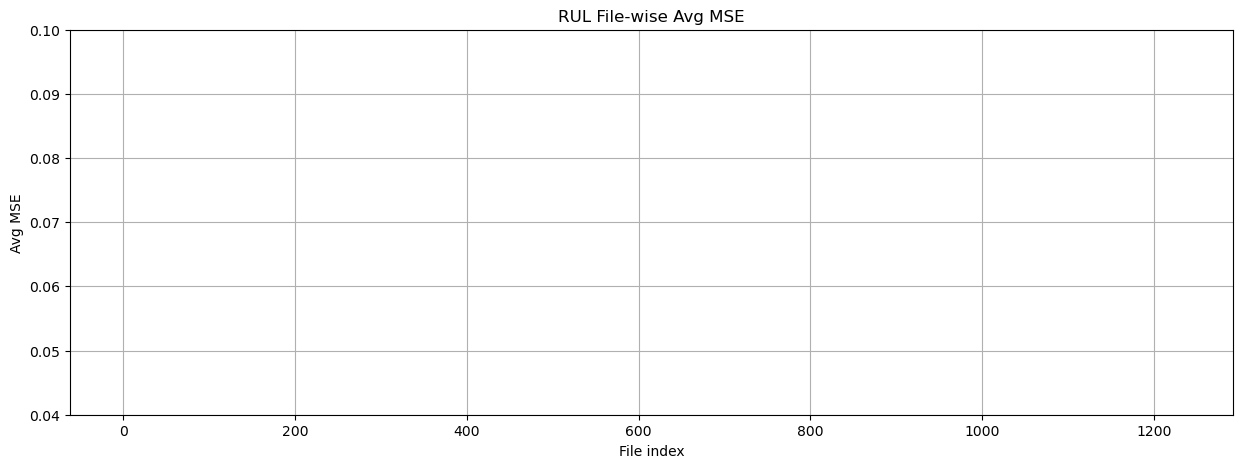

In [ ]:
# 自行修改成你的資料路徑
RUL_test_folder = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0716_3000_10p_1.0V_5"
Rs=12.5
F=20000
augmen_sample_number = 100

# 主程式：取得每個檔案的平均 MSE
errors3 = process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs)


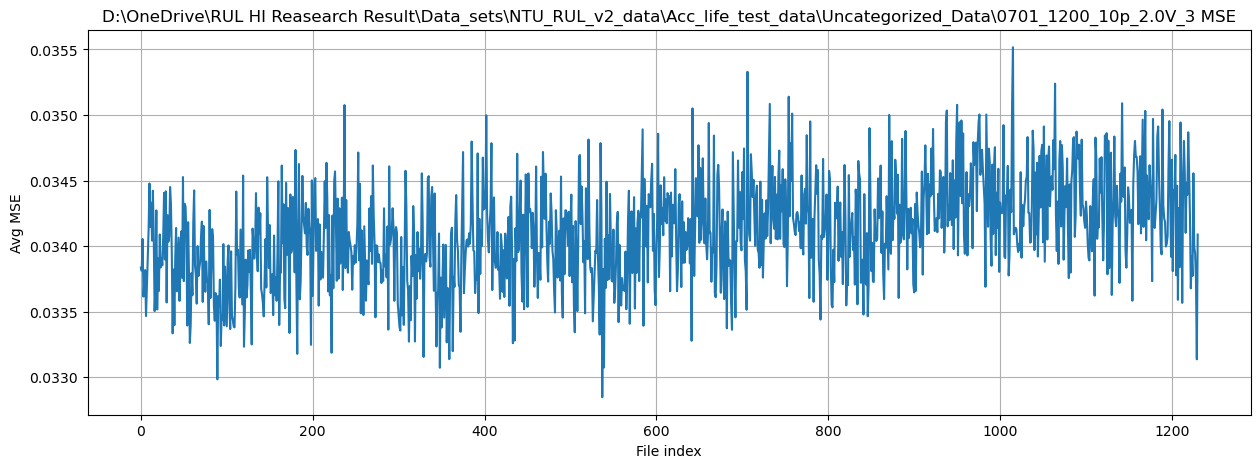

In [42]:

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors3)
plt.title(f"{RUL_test_folder} MSE")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()